In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

# 读取数据
df = pd.read_csv('../input/merged_data_ALL3.csv')

X = df[['001_SS_Close', '399_SZ_Close', 'HIS_Close', 'IXIC_Close', 'FTSE_Close', 'JM0_Close']]
y = df['600_Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# 创建DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [3]:
import torch.nn as nn
import torch.optim as optim

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


input_size = X_train_tensor.shape[1]
hidden_size = 50
output_size = 1
model_rnn = RNNModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_rnn.parameters(), lr=0.001)

num_epochs = 50
model_rnn.train()
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_rnn(X_batch.unsqueeze(1))  # 增加时间步维度
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 评估RNN模型
model_rnn.eval()
with torch.no_grad():
    y_pred_rnn = model_rnn(X_test_tensor.unsqueeze(1))
    rnn_mse = criterion(y_pred_rnn, y_test_tensor).item()
    print("RNN的均方误差:", rnn_mse)


Epoch [10/50], Loss: 44.4824
Epoch [20/50], Loss: 9.4144
Epoch [30/50], Loss: 0.7370
Epoch [40/50], Loss: 0.2438
Epoch [50/50], Loss: 0.2140
RNN的均方误差: 0.29902902245521545


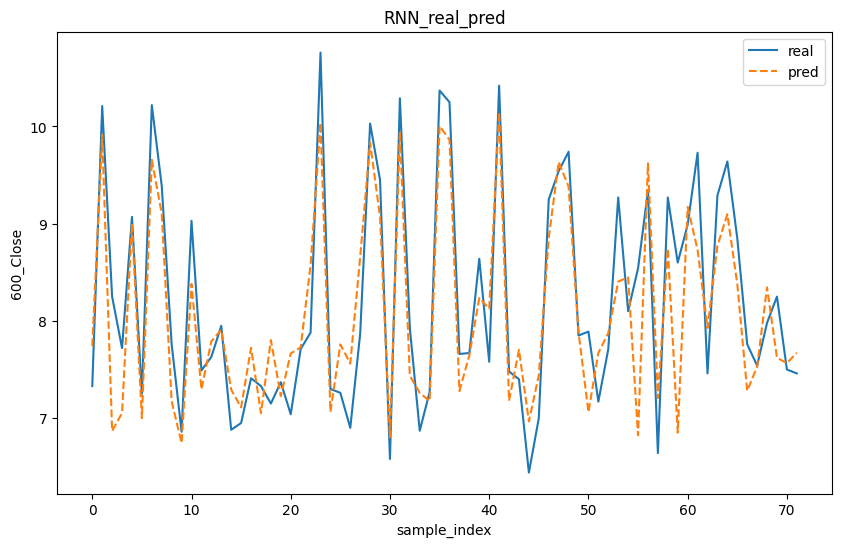

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_tensor.numpy(), label='real')
plt.plot(y_pred_rnn.numpy(), label='pred', linestyle='--')
plt.legend()
plt.title('RNN_real_pred')
plt.xlabel('sample_index')
plt.ylabel('600_Close')
plt.show()


In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model_lstm = LSTMModel(input_size, hidden_size, output_size)
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

model_lstm.train()
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_lstm(X_batch.unsqueeze(1))  # 增加时间步维度
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


model_lstm.eval()
with torch.no_grad():
    y_pred_lstm = model_lstm(X_test_tensor.unsqueeze(1))
    lstm_mse = criterion(y_pred_lstm, y_test_tensor).item()
    print("LSTM的均方误差:", lstm_mse)


Epoch [10/50], Loss: 54.8777
Epoch [20/50], Loss: 28.9075
Epoch [30/50], Loss: 7.8259
Epoch [40/50], Loss: 1.3178
Epoch [50/50], Loss: 0.3301
LSTM的均方误差: 0.37961381673812866


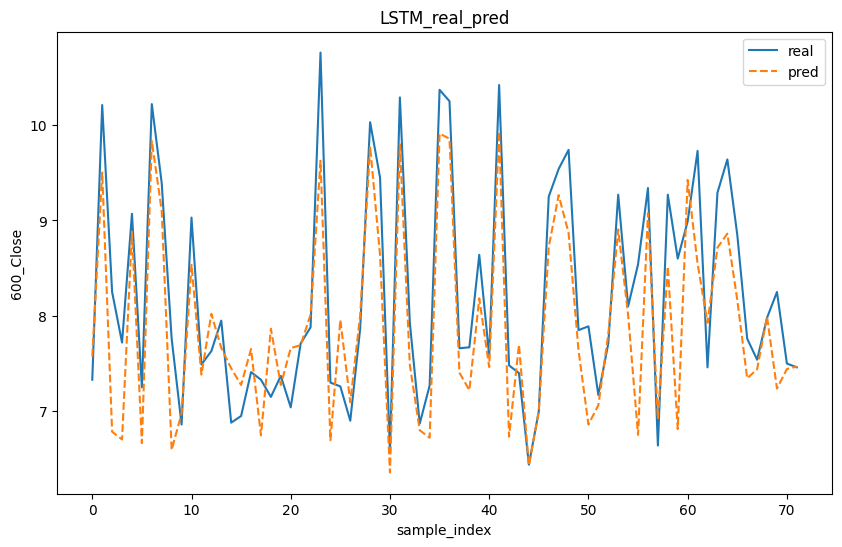

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_tensor.numpy(), label='real')
plt.plot(y_pred_lstm.numpy(), label='pred', linestyle='--')
plt.legend()
plt.title('LSTM_real_pred')
plt.xlabel("sample_index")
plt.ylabel('600_Close')
plt.show()
